# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

**Assignment**
Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
   * Excel and Vensim are only supported on Windows
   * Vensim requires the DSS version of Vensim
   * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get [NetLogo 6.3.0](https://ccl.northwestern.edu/netlogo/download.shtml)
   * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
   * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).


|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes [example scripts](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples) for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).
  * This [tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) also shows a simple model in Python, Vensim and Excel connected to the workbench.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (
    Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging
)
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.salib_samplers import MorrisSampler, SobolSampler

from ema_workbench.analysis.plotting import lines, Density


c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\connectors\__init__.py:19: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


In [2]:
import sys
import os
import jpype
# Instantia
sys.path.append(os.path.abspath('model'))


In [3]:
# Import the Python function
from pred_prey import PredPrey

class PatchedNetLogoModel(NetLogoModel):
    def model_init(self, policy):
        import jpype
        if not jpype.isJVMStarted():
            jpype.startJVM(r"C:\Program Files\Eclipse Adoptium\jdk-11.0.27.6-hotspot\bin\server\jvm.dll")
        super().model_init(policy)
def getmod(function, mod_ki='py', **kwargs):
    if mod_ki == 'py':
        model = Model('pred', function=function)
    elif mod_ki == 'exc':
        print('excel')
        path = kwargs.get('path', None)
        model = ExcelModel('pred', wd="./model", model_file=path)
        model.default_sheet = 'Sheet1'
    elif mod_ki == 'netlogo':
        path = kwargs.get('path', None)
        model = PatchedNetLogoModel('pred', wd="./model", model_file=path)
    return model
model = getmod(PredPrey, mod_ki= 'netlogo',path = "PredPrey.nlogo")
#model.time_horizon = 365/0.25
# Specify uncertainties



In [4]:
from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    ema_logging,
    MultiprocessingEvaluator,
    Constraint,
)

# Define uncertainties and outcomes
model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08),
                       ]


# Define model objects for the different implementations



model.outcomes = [
    TimeSeriesOutcome('TIME'),
    TimeSeriesOutcome('predators'),
    TimeSeriesOutcome('prey')
]



In [ ]:
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress
from ema_workbench.em_framework.evaluators import Samplers


# with MultiprocessingEvaluator(model) as evaluator:
#     experimenents, outcomes = evaluator.perform_experiments(n_scenarios, n_policies, lever_sampling=Samplers.MC)
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1)

Error retrieving default JVM path: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.
Starting JVM...


  0%|                                                    | 0/1 [00:00<?, ?it/s]No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.
Traceback (most recent call last):
  File "c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 92, in run_experiment
    model.run_model(scenario, policy)
  File "c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\util\ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
  File "c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\em_framework\model.py", line 307, in run_model
    super().run_model(scenario, policy)
  File "c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\util\ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
  File "c:\Users\juliu\anaconda3\envs\gds24\lib\site-packages\ema_workbench\em_framework\model.py", line 184, in run_model
    self.model_in

EMAError: Exception in run_model
Caused by: JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

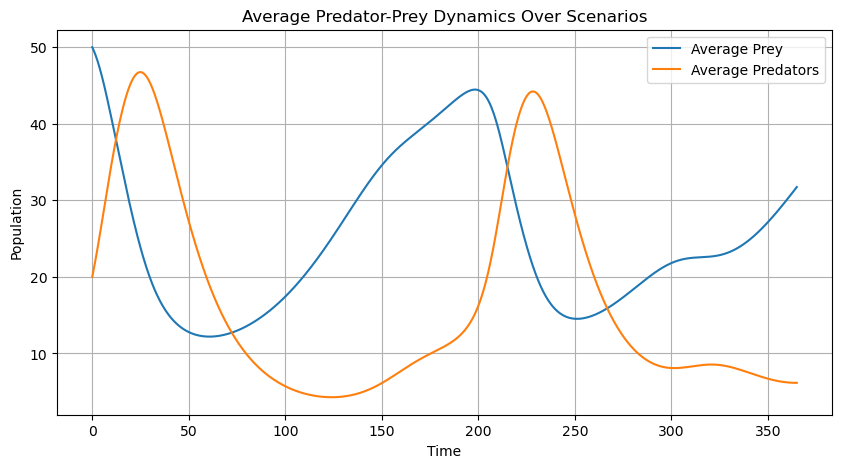

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten just the time once (time is the same for all scenarios)
time = outcomes['TIME'][0].flatten()

# Compute mean across all scenarios (axis=0 = across experiments)
mean_prey = np.mean(outcomes['prey'], axis=0).flatten()
mean_predators = np.mean(outcomes['predators'], axis=0).flatten()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, mean_prey, label='Average Prey')
plt.plot(time, mean_predators, label='Average Predators')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Average Predator-Prey Dynamics Over Scenarios')
plt.legend()
plt.grid(True)
plt.show()
